In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import os
import joblib
import json

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

!pip install bert-for-tf2 # TensorFlow 2.0 implementation of BERT
import bert

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
import tensorflow_hub as tf_hub # needed for importing BERT as a Keras Layer
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau

Processing /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab/bert_for_tf2-0.14.4-cp36-none-any.whl
Processing /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980/py_params-0.9.7-cp36-none-any.whl
Processing /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06/params_flow-0.8.2-cp36-none-any.whl


# EDA

In [0]:
df = pd.read_csv('/content/drive/My Drive/Twitter/train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### Missing values

In [0]:
missing = (df.isnull().sum()/len(df)*100).round(2)
pd.DataFrame({'% missing values': missing})

,% missing values
id,0.00
keyword,0.80
location,33.27
text,0.00
target,0.00


### Remove unnecessary columns

In [0]:
df.drop(['id','keyword','location'], axis=1, inplace = True) 

Although 'keywords' doesnt have alot of missing values, I'm dropping it because I dont think I will need it as an additional input. Text alone should be fine. Maybe in the future I might consider including keywords

### Class distribution

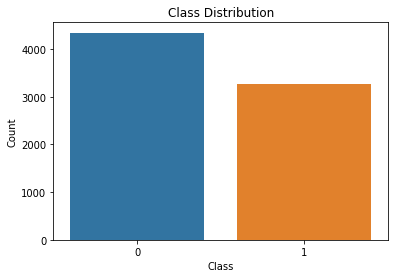

In [0]:
ax = sns.countplot(x = 'target', data = df)
ax.set(xlabel='Class', ylabel='Count', title = 'Class Distribution')
plt.show()

There are more Non-disaster than Disaster tweets 

### Total number of words in each tweet

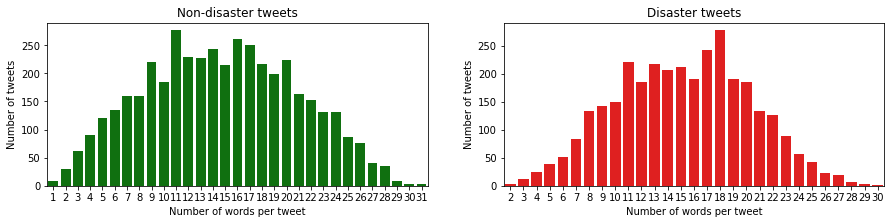

In [0]:
df_len_0 = df[df['target']==0]['text'].str.split().map(lambda x: len(x))
df_len_1 = df[df['target']==1]['text'].str.split().map(lambda x: len(x)) 

fig, axes = plt.subplots(1, 2, figsize=(15,3))

sns.countplot(df_len_0, ax=axes[0], color='green')
axes[0].set(xlabel='Number of words per tweet', ylabel='Number of tweets', title='Non-disaster tweets')

sns.countplot(df_len_1, ax=axes[1], color='red')
axes[1].set(xlabel='Number of words per tweet', ylabel='Number of tweets', title='Disaster tweets')

plt.show()

The distribution for number of words per tweet looks similar between disaster and non-disaster tweets 

# Data Cleaning

In [0]:
def clean(text):
    
  text = text.lower()

  #Read from JSON file to fix contractions, special characters, abbreviations, typos
  file_r = open('/content/drive/My Drive/Twitter/clean_json.txt',"r",encoding="utf-8")
  clean_dict = json.load(file_r)
  file_r.close()

  for key in clean_dict:
    text = re.sub(key, clean_dict[key], text) 
  
  #Remove URL
  pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') 
  text = pattern.sub('', text)    
  
  #Punctuations are separated from words
  punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' # this list is from "string.punctuation"
  for p in punctuations:
    text = text.replace(p, f' {p} ') 

  # Separating ... and .. from words by adding spaces
  text = text.replace('...', ' ... ')
  if '...' not in text:
    text = text.replace('..', ' ... ')   
  
  return text

In [0]:
sample_sentence = "Check if punctuations such as !@#$%^&*()_+=-[];'\|~`./,{}:?>< . .. ... are separated"
clean(sample_sentence)

"check if punctuations such as  !  @  #  $  %  ^  &  *  (  )  _  +  =  -  [  ]  ;  '  \\  |  ~  `  .  /  ,  {  }  :  ?  >  <   .   .  .   .  .  .  are separated"

In [0]:
sample_sentence = "Check if URL such as https://www.kaggle.com/c/nlp-getting-started are removed"
clean(sample_sentence)

'check if url such as  are removed'

In [0]:
# check if contractions, special characters, abbreviations, and typos are fixed
sample_sentence = "aren't, america\x89ûªs, 16yr, mediterran" 
clean(sample_sentence)

'are not ,  america ,  16 year ,  mediterranean'

In [0]:
df['text_cleaned'] = df['text'].apply(lambda series : clean(series))

# Train Model

In [0]:
# import the pre-trained BERT model as Keras Layer
bert_layer = tf_hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)

In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case) 

In [0]:
max_seq_len = 128

In [0]:
def encode(texts, max_seq_length = max_seq_len): # function for encoding input tweets
                
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts: 
        text = tokenizer.tokenize(text) 
        text = text[:max_seq_length - 2] 
        input_sequence = ['[CLS]'] + text + ['[SEP]'] 
        pad_len = max_seq_length - len(input_sequence) 

        tokens = tokenizer.convert_tokens_to_ids(input_sequence) 
        tokens += [0] * pad_len 
        
        pad_masks = [1] * len(input_sequence) + [0] * pad_len 
        
        segment_ids = [0] * max_seq_length 

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
def build_model(max_seq_length = max_seq_len): 

    # 3 Inputs
    input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids') 
    input_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name='segment_ids')    
 
    # pass the 3 inputs to the BERT layer, and output contextual embeddings
    pooled_embed, sequence_embed = bert_layer([input_word_ids, input_mask, segment_ids]) 
    
    CLS_embed = sequence_embed[:,0,:] # embedding of [CLS] token
    output = Dense(1, activation='sigmoid')(CLS_embed) # pass CLS_embed as input to the Output Layer
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], 
                  outputs=output) 

    model.compile(loss='binary_crossentropy', 
                  optimizer=SGD(learning_rate=1e-4, momentum=0.8), 
                  metrics=['accuracy'])

    return model

In [0]:
# Create validation set, stratified based on target class distribution
s = StratifiedShuffleSplit(test_size=0.2, random_state=42)

for train_index, val_index in s.split(df, df["target"]): 
    train = df.loc[train_index]
    val = df.loc[val_index]
    
train.reset_index(inplace=True, drop=True) 
val.reset_index(inplace=True, drop=True) 

In [0]:
X_train_encoded = encode(train['text_cleaned'].str.lower()) # outputs a tuple of 3 arrays
y_train = np.array(train['target'])

X_val_encoded = encode(val['text_cleaned'].str.lower()) # outputs a tuple of 3 arrays
y_val = np.array(val['target'])

In [0]:
# Callbacks
checkpoint = ModelCheckpoint("/content/drive/My Drive/Twitter/bert_model_2",                                                 
                              monitor = 'val_loss',                                                
                              save_best_only=True) # save the model with the lowest val_loss

early_stop = EarlyStopping(monitor = 'val_loss', patience=4)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=1, verbose=1, factor=0.5)

# Model
model = build_model()        
history = model.fit(X_train_encoded, 
                    y_train, 
                    validation_data=(X_val_encoded, y_val), 
                    epochs=15, 
                    batch_size=32,
                    callbacks=[checkpoint, early_stop, lr_scheduler],
                    verbose=2)

Epoch 1/15
INFO:tensorflow:Assets written to: /content/drive/My Drive/Twitter/bert_model_2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Twitter/bert_model_2/assets


191/191 - 311s - loss: 0.4599 - accuracy: 0.7961 - val_loss: 0.4222 - val_accuracy: 0.8221 - lr: 1.0000e-04
Epoch 2/15
191/191 - 299s - loss: 0.3959 - accuracy: 0.8397 - val_loss: 0.4359 - val_accuracy: 0.8148 - lr: 1.0000e-04
Epoch 3/15
INFO:tensorflow:Assets written to: /content/drive/My Drive/Twitter/bert_model_2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Twitter/bert_model_2/assets


191/191 - 310s - loss: 0.3926 - accuracy: 0.8353 - val_loss: 0.4167 - val_accuracy: 0.8267 - lr: 1.0000e-04
Epoch 4/15
INFO:tensorflow:Assets written to: /content/drive/My Drive/Twitter/bert_model_2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Twitter/bert_model_2/assets


191/191 - 310s - loss: 0.3797 - accuracy: 0.8438 - val_loss: 0.4138 - val_accuracy: 0.8280 - lr: 1.0000e-04
Epoch 5/15
INFO:tensorflow:Assets written to: /content/drive/My Drive/Twitter/bert_model_2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Twitter/bert_model_2/assets


191/191 - 310s - loss: 0.3690 - accuracy: 0.8509 - val_loss: 0.4073 - val_accuracy: 0.8240 - lr: 1.0000e-04
Epoch 6/15
191/191 - 298s - loss: 0.3640 - accuracy: 0.8535 - val_loss: 0.4167 - val_accuracy: 0.8234 - lr: 1.0000e-04
Epoch 7/15
191/191 - 298s - loss: 0.3588 - accuracy: 0.8589 - val_loss: 0.4120 - val_accuracy: 0.8260 - lr: 1.0000e-04
Epoch 8/15

Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
191/191 - 298s - loss: 0.3557 - accuracy: 0.8585 - val_loss: 0.4163 - val_accuracy: 0.8260 - lr: 1.0000e-04
Epoch 9/15
191/191 - 298s - loss: 0.3488 - accuracy: 0.8575 - val_loss: 0.4132 - val_accuracy: 0.8253 - lr: 5.0000e-05


# Evaluate Model

### Plot: Loss VS Epoch

In [0]:
def plot_graphs(history, metric):
    joblib.dump(history.history[metric], "/content/drive/My Drive/Twitter/train_BERT" + metric + ".pkl") #save training metric
    joblib.dump(history.history['val_' + metric], "/content/drive/My Drive/Twitter/val_BERT" + metric + ".pkl") #save validation metric
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric])

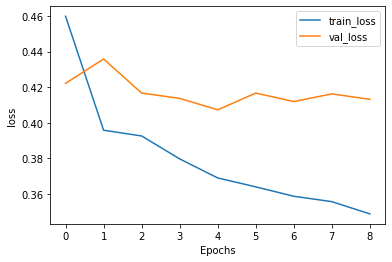

In [0]:
plot_graphs(history, "loss")

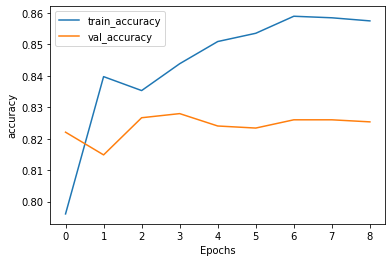

In [0]:
plot_graphs(history, "accuracy")

### Confusion Matrix

In [0]:
y_pred = model.predict (X_val_encoded) 
y_pred = np.round(y_pred).astype(int).reshape((y_pred.shape[0])) # round to either 0 or 1

y_true = y_val.reshape((y_val.shape[0])) 

conf = confusion_matrix (y_true, y_pred) 
conf

array([[747, 122],
       [144, 510]])

In [0]:
TP = conf[1,1] # true positives
TN = conf[0,0] # true negatives
FP = conf[0,1] # false positives
FN = conf[1,0] # false negatives

print(f"The model incorrectly classified {FP/(TN+FP)*100:.0f}% of the {val['target'].shape[0] - val['target'].sum()} non-disaster tweets and {FN/(FN+TP)*100:.0f}% of the {val['target'].sum()} disaster tweets")

print(f"Precision score =: {precision_score(y_true,y_pred):.2f}")
print(f"Recall score =: {recall_score(y_true,y_pred):.2f}")
print(f"F1 score =: {f1_score(y_true,y_pred):.2f}")

The model incorrectly classified 14% of the 869 non-disaster tweets and 22% of the 654 disaster tweets
Precision score =: 0.81
Recall score =: 0.78
F1 score =: 0.79


### Write the misclassified tweets to CSV file to perform error analysis

In [0]:
# These setting below allow me to view the entire tweet
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
pd.set_option('display.max_colwidth', 50)

*tokenizer.convert_ids_to_tokens* only accepts single array of id. So, I had to perform a list comprehension *(see below)* to convert the id to token for each misclassified tweet

In [0]:
error_df = val[y_pred != y_true].reset_index(drop=True) # misclassified tweets 

id_array = X_val_encoded[0][y_pred != y_true] # array of id for all misclassified tweets

# store the tokens of each misclassified tweets into a list
token_list = [tokenizer.convert_ids_to_tokens(id_array[i]) for i in range (id_array.shape[0])] 

error_df.insert(1,'tokenized', token_list) 

error_df = error_df.rename(columns = {'text':'raw', 'target': 'y_true', 'text_cleaned':'cleaned'})
error_df = error_df[["raw", "cleaned", "tokenized", "y_true"]]

error_df.to_csv('/content/drive/My Drive/Twitter/error_analysis_BERT2.csv', index = False)

# Evaluate on Submission Set

In [0]:
model = load_model('/content/drive/My Drive/Twitter/bert_model_2') 

In [0]:
sub_df = pd.read_csv('/content/drive/My Drive/Twitter/test.csv')

sub_id = sub_df['id']
sub_df.drop(['id','keyword','location'], axis=1, inplace = True) 

sub_df['text_cleaned'] = sub_df['text'].apply(lambda series : clean(series))
sub_df_encoded = encode(sub_df['text_cleaned'].str.lower()) # outputs a tuple of 3 arrays

In [0]:
y_pred = model.predict (sub_df_encoded) 
y_pred = np.round(y_pred).astype(int).reshape((y_pred.shape[0])) # round to 0 to 1

In [0]:
df = pd.DataFrame({'id': sub_id, 'target': y_pred})
df.to_csv('/content/drive/My Drive/Twitter/twitter_submission_5.csv', index = False)

# Reference and Acknowledgments
Some of the code involved in the implementation of BERT were inspired by Gunes Evitan's notebook (https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)